Malo o projektu: Određivanje rase pasa na osnovu unete slike 

### **Faza1**: Analiza podataka

Analiza podataka će omogućiti razumevanje skupa podataka koji će se koristiti za treniranje modela veštačke inteligencije. Ova faza biće realizovana u nekoliko koraka.

Skup podataka je preuzet sa [Dog Breeds Image Dataset on Kaggle](https://www.kaggle.com/datasets/darshanthakare/dog-breeds-image-dataset) i sačuvan je u folderu projekta na putanji data/DogBreedsImageDataset

Sve korišćene biblioteke navedene su u prvoj Code ćeliji 👇🏻

In [18]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import seaborn as sns
import numpy as np
from matplotlib import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
import shutil
from collections import Counter
import time

Prebrojavanje koliko klasa (rasa) se nalazi u skupu podataka.


In [177]:
data_root = Path("data/DogBreedsImageDataset")
classes = [p for p in data_root.iterdir() if p.is_dir()]
print("Broj rasa:", len(classes))

Broj rasa: 157


Ukupan broj slika u skupu podataka.

In [178]:
image_count = len(list(data_root.glob('*/*.jpg')))
print("Ukupno slika:", image_count)

Ukupno slika: 17498


Provera da li je neki od foldera prazan.

In [179]:
empty_classes = []

for cls in classes:
    cls_path = cls
    # broji sve .jpg fajlove
    count = len([f for f in cls_path.iterdir() if f.suffix.lower() == '.jpg'])
    if count == 0:
        empty_classes.append(cls_path.name)

if empty_classes:
    print("Prazni folderi (nema slika):")
    for cls in empty_classes:
        print(cls)
else:
    print("Nema praznih foldera. Sve klase imaju slike.")

Nema praznih foldera. Sve klase imaju slike.


Izračunati su broj klasa (rasa) i ukupan broj slika. Sada se računa broj slika po klasama. 

In [180]:
print("Broj slika po klasama:")

image_per_class=[]
for cls in classes:
    cls_path = cls  # cls već sadrži Path do foldera
    count = len([f for f in cls_path.iterdir() if f.suffix.lower() == '.jpg'])
    image_per_class.append(count)
    print(f"{cls_path.name}: {count} slika")

Broj slika po klasama:
affenpinscher: 134 slika
afghan_hound: 125 slika
african: 169 slika
airedale: 189 slika
akita: 7 slika
american_terrier: 153 slika
appenzeller: 135 slika
australian_cattledog: 18 slika
australian_terrier: 181 slika
basenji: 170 slika
basset_hound: 149 slika
beagle: 172 slika
bedlington_terrier: 148 slika
bernese_mountain: 190 slika
bichon_frise: 11 slika
blenheim_spaniel: 157 slika
blood_hound: 135 slika
bluetick: 147 slika
border_collie: 155 slika
border_terrier: 147 slika
borzoi: 107 slika
boston_bulldog: 173 slika
bouvier: 119 slika
boxer: 149 slika
brabancon: 141 slika
briard: 136 slika
brittany_spaniel: 136 slika
bull_mastiff: 137 slika
cairn_terrier: 177 slika
cardigan_corgi: 132 slika
caucasian_ovcharka: 30 slika
cavapoo: 5 slika
chesapeake_retriever: 142 slika
chihuahua: 129 slika
chow: 183 slika
clumber: 116 slika
cockapoo: 16 slika
cocker_spaniel: 174 slika
coonhound: 130 slika
cotondetulear: 4 slika
curly_retriever: 129 slika
dachshund: 31 slika
dalmat

Ove podatke je moguće vizuelizovati. Koristi se *import matplotlib.pyplot as plt* za kreiranje horizontalnog bar grafa (<span style="color:pink">barh</span>). Rase su poređane abecedno, kako su i navedene u skupu podataka. 

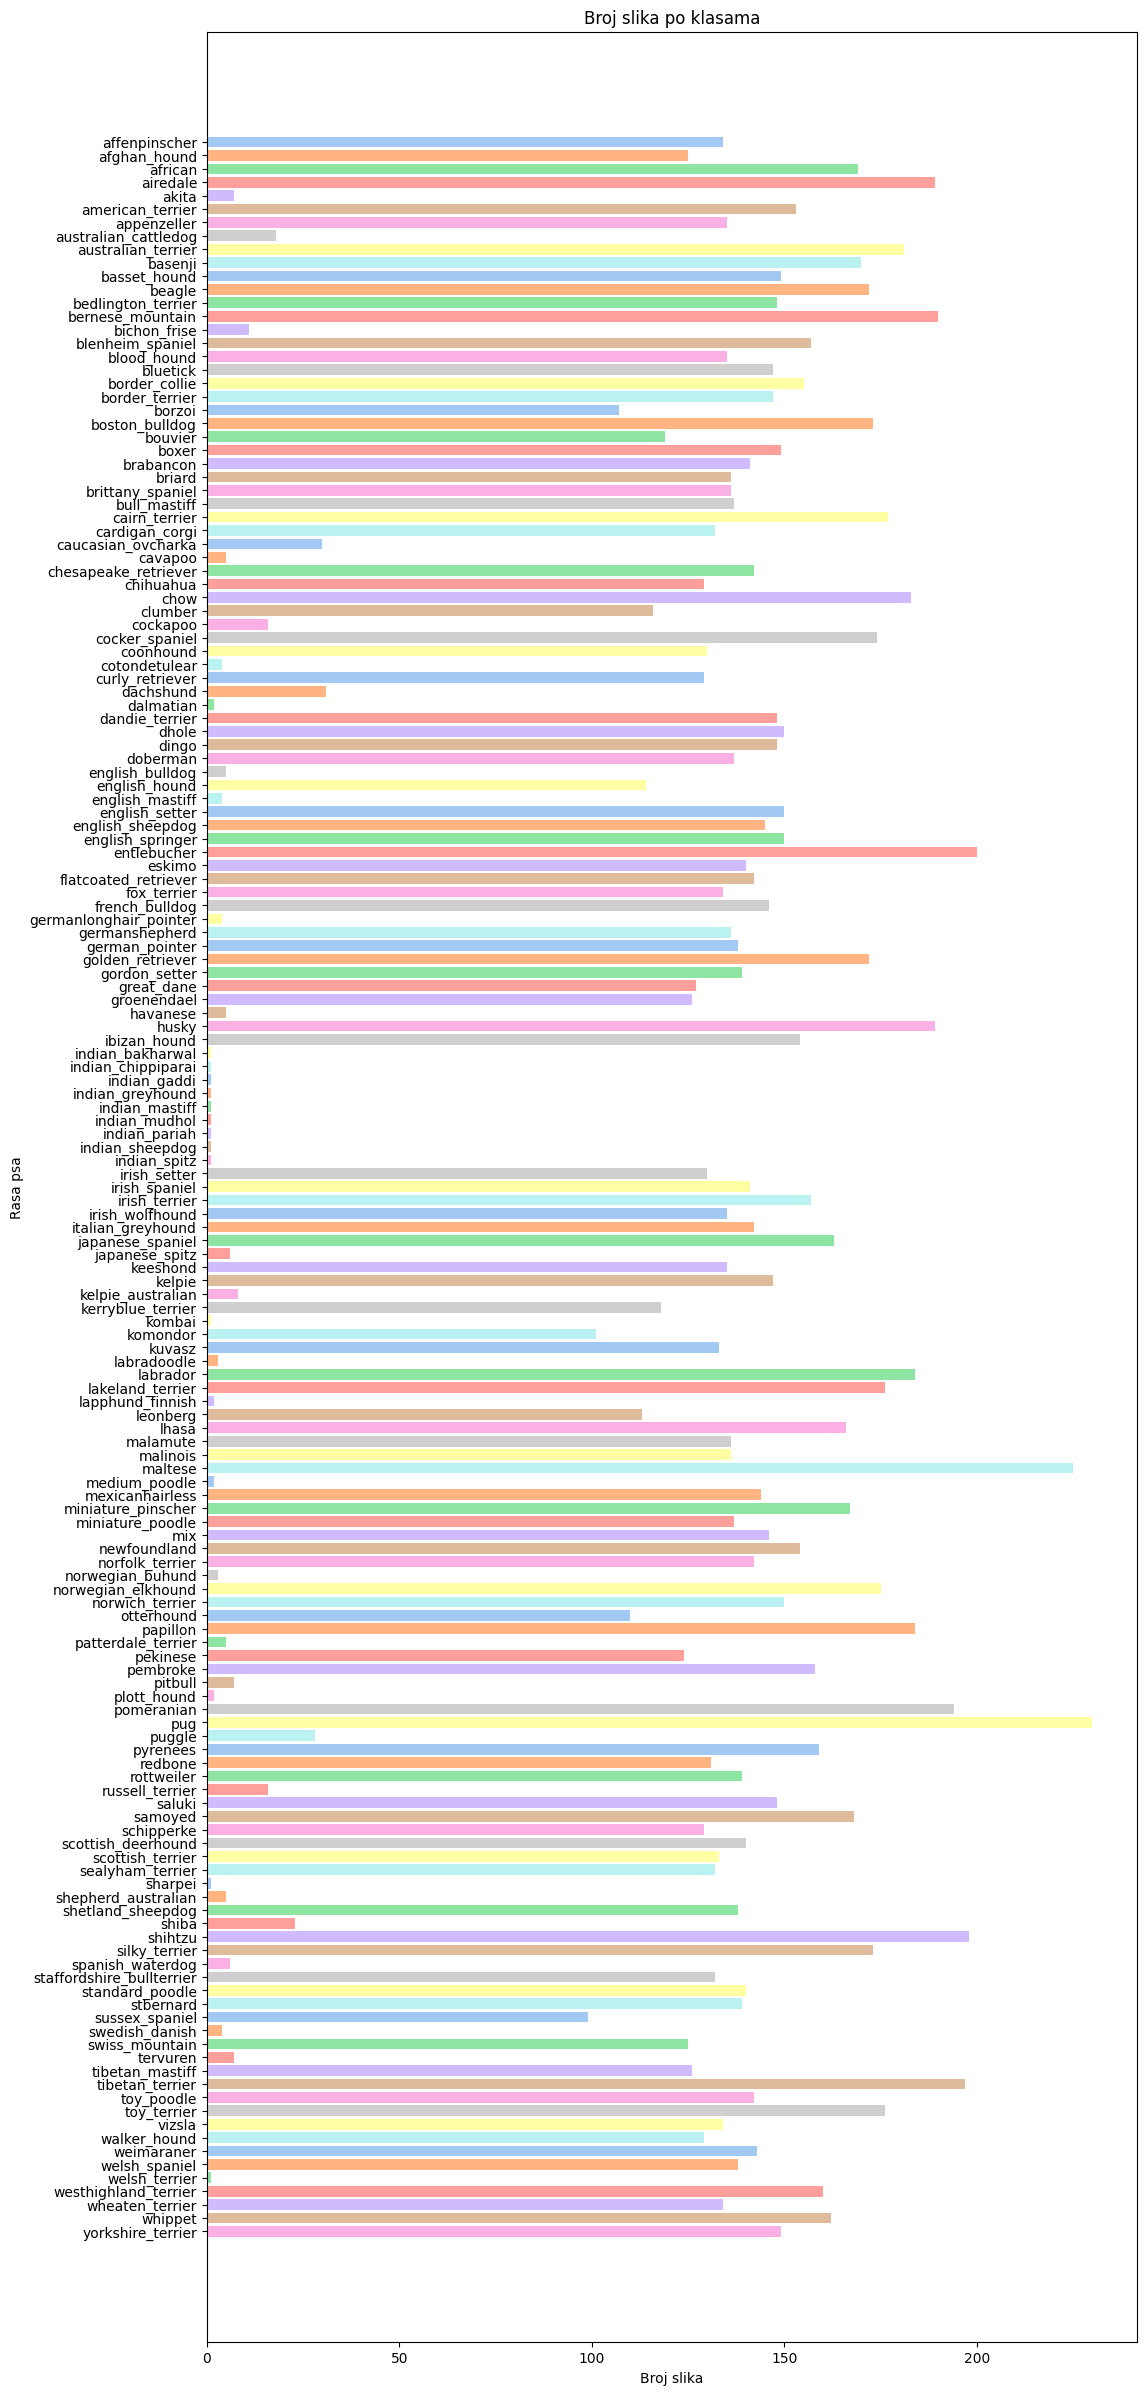

In [181]:
class_names = [cls.name for cls in classes] 

plt.figure(figsize=(12,30))
colors = sns.color_palette("pastel", len(classes))
plt.barh(class_names, image_per_class, color=colors)
plt.xlabel('Broj slika')
plt.ylabel('Rasa psa')
plt.title('Broj slika po klasama')
plt.gca().invert_yaxis()  # najviše slike gore
plt.show()

Sledeći graf prikazuje broj slika po rasama od najvećeg broja slika po klasi do najmanjeg. 

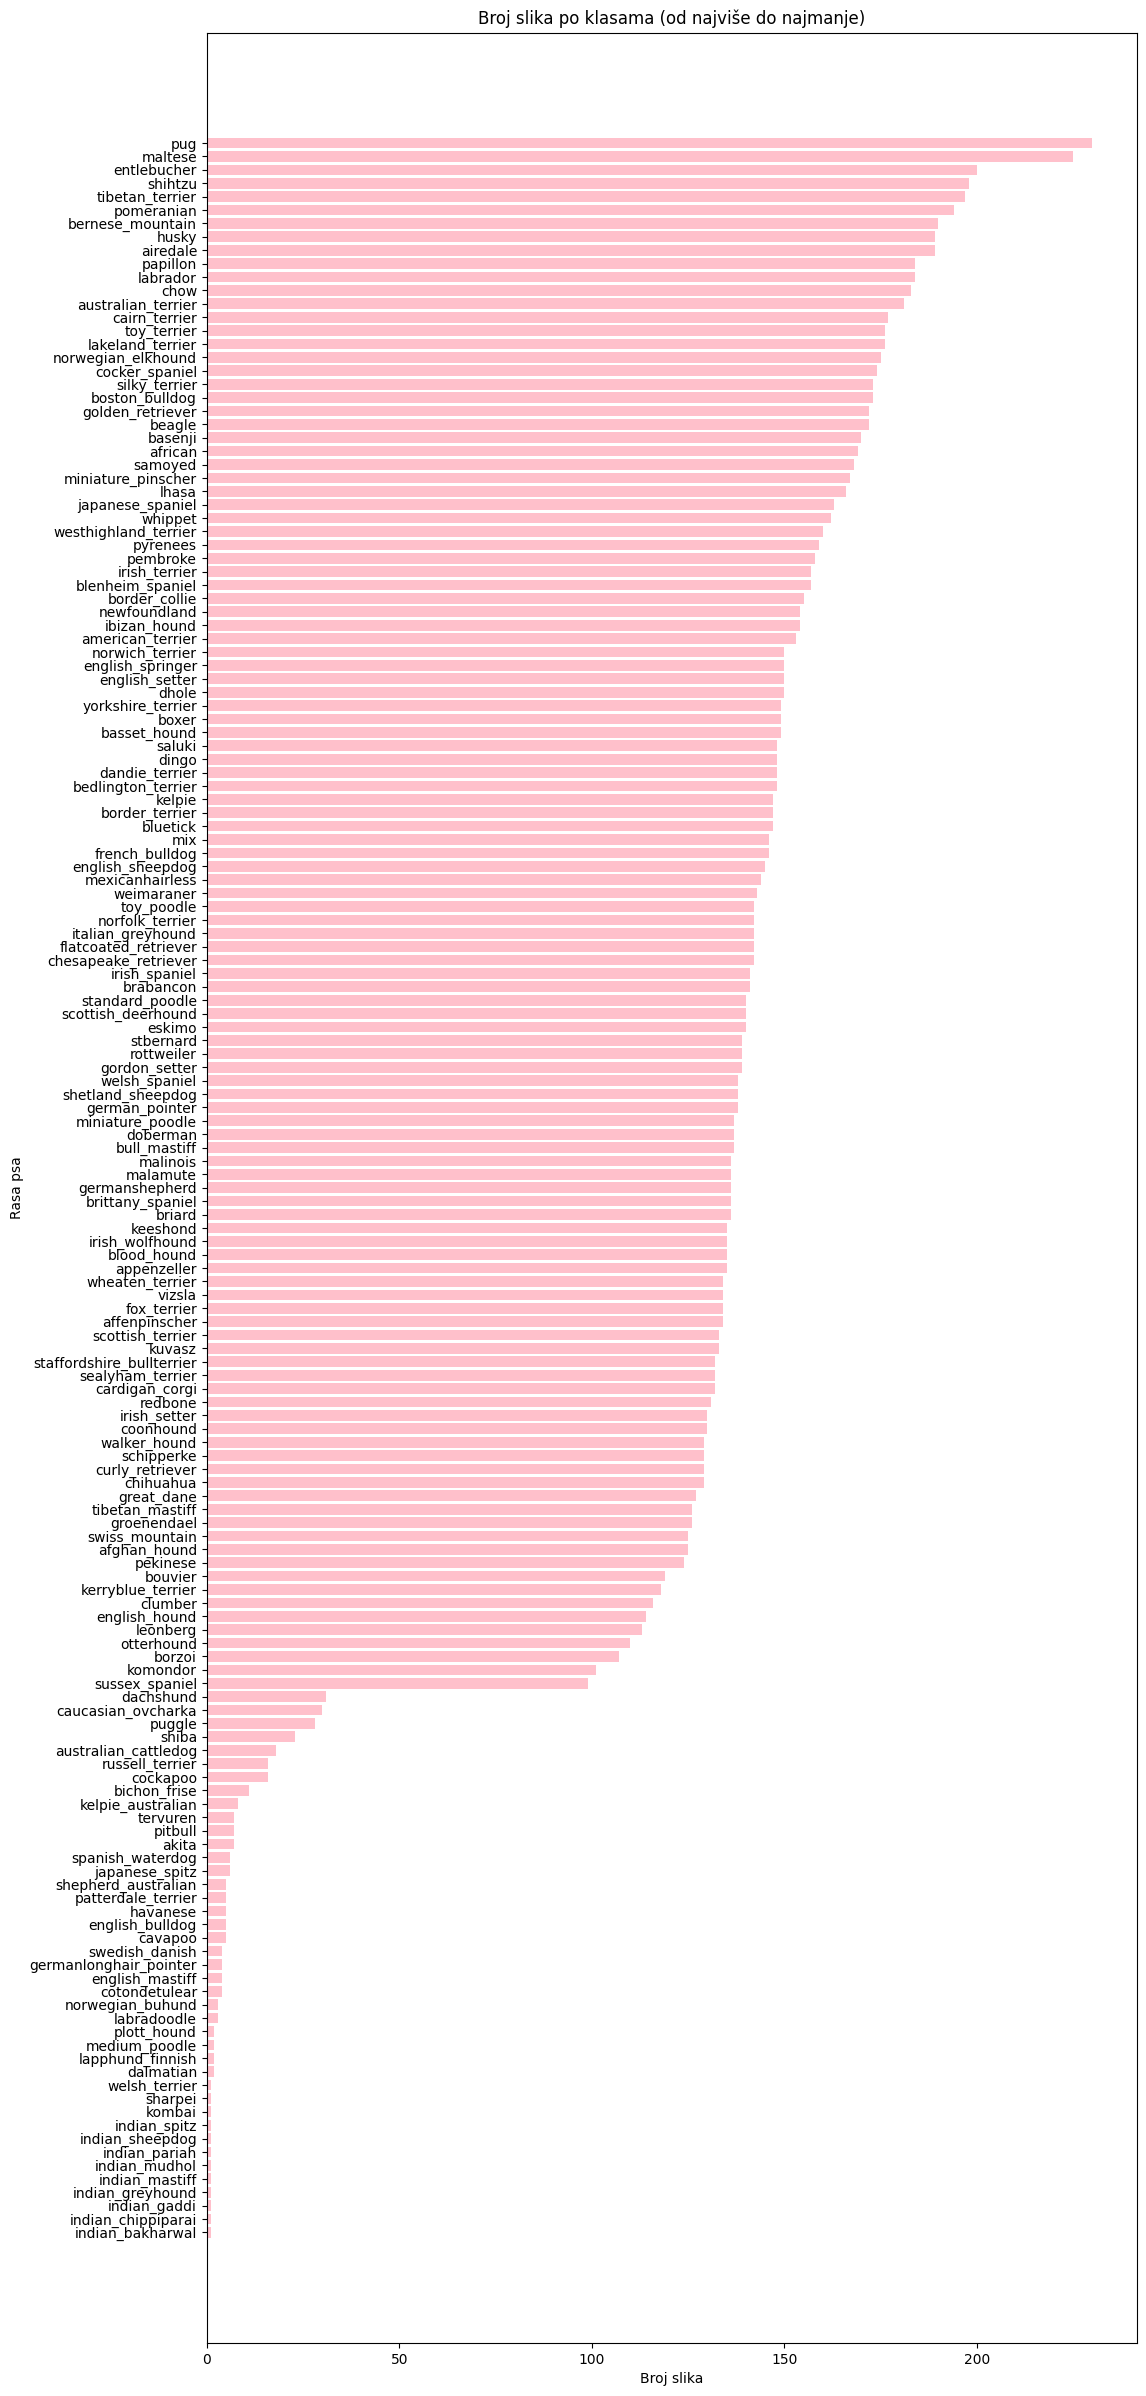

In [182]:
# Sortiranje po broju slika (od najviše do najmanje)
sorted_pairs = sorted(zip(image_per_class, class_names), reverse=True)
sorted_counts, sorted_classes = zip(*sorted_pairs)

# Horizontalni bar graf
plt.figure(figsize=(12,30))
plt.barh(sorted_classes, sorted_counts, color='pink')
plt.xlabel('Broj slika')
plt.ylabel('Rasa psa')
plt.title('Broj slika po klasama (od najviše do najmanje)')
plt.gca().invert_yaxis()  # najviše slika gore
plt.show()

Precizno određujemo koji je najmanji a koji najveći broj slika po klasama. Na osnovu grafika iznad može se proceniti da veći broj klasa ima najmanji broj slika, pa se ispisuju sve klase sa najvećim i sa najmanjim brojem.  

In [183]:
min_count = min(image_per_class)
max_count = max(image_per_class)

# foldere koji imaju min i max broj slika
min_classes = [cls.name for cls, count in zip(classes, image_per_class) if count == min_count]
max_classes = [cls.name for cls, count in zip(classes, image_per_class) if count == max_count]

print(f"Folderi sa najmanje slika ({min_count}): {min_classes}")
print(f"Folderi sa najviše slika ({max_count}): {max_classes}")

Folderi sa najmanje slika (1): ['indian_bakharwal', 'indian_chippiparai', 'indian_gaddi', 'indian_greyhound', 'indian_mastiff', 'indian_mudhol', 'indian_pariah', 'indian_sheepdog', 'indian_spitz', 'kombai', 'sharpei', 'welsh_terrier']
Folderi sa najviše slika (230): ['pug']


Prikaz podataka (slika), i to po 3 primerka za prvih 5 klasa.

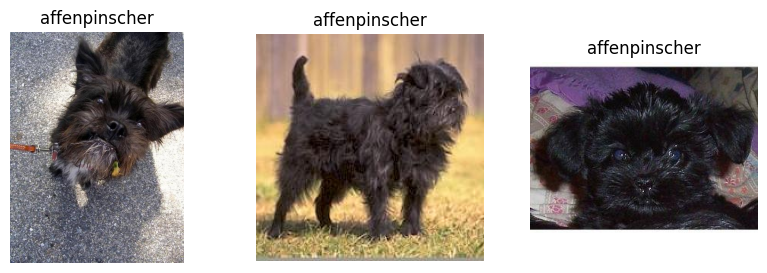

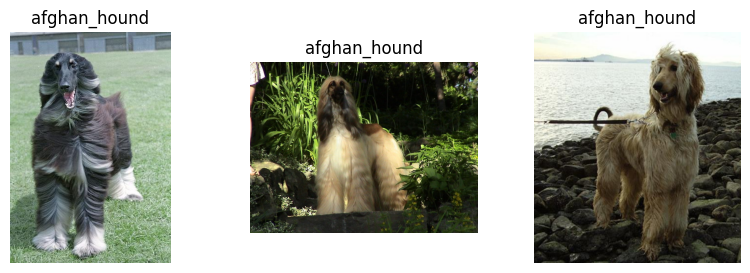

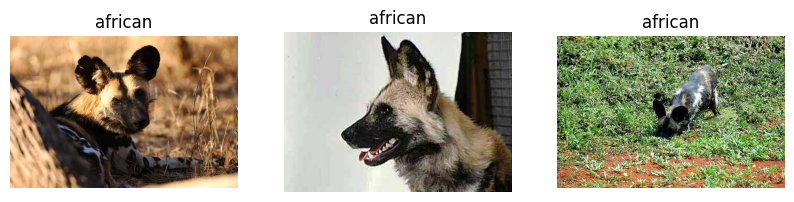

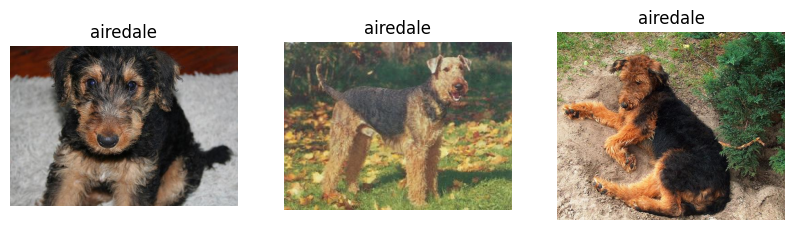

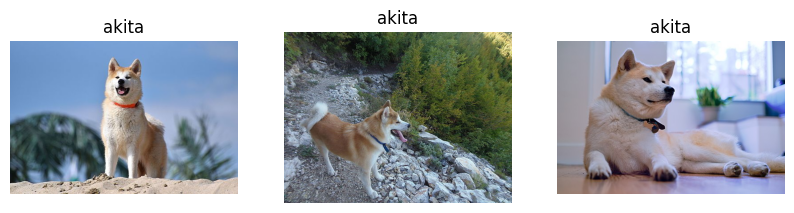

In [184]:
for cls in classes[:5]:
    imgs = list(cls.iterdir())
    random_imgs = random.sample(imgs, min(3, len(imgs)))
    plt.figure(figsize=(10,3))
    for i, img_path in enumerate(random_imgs):
        img = Image.open(img_path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls.name)
    plt.show()

Možemo primetiti da slike nisu istih dimenzija! Taj deo će biti obrađen u narednoj fazi, odnosno u okviru predprocesiranja podataka, a u nastavku če biti analizirane dimenzije slika.

In [185]:
widths, heights = [], []

for cls in classes:
    for img_path in cls.iterdir():
        if img_path.suffix.lower() == '.jpg':
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)



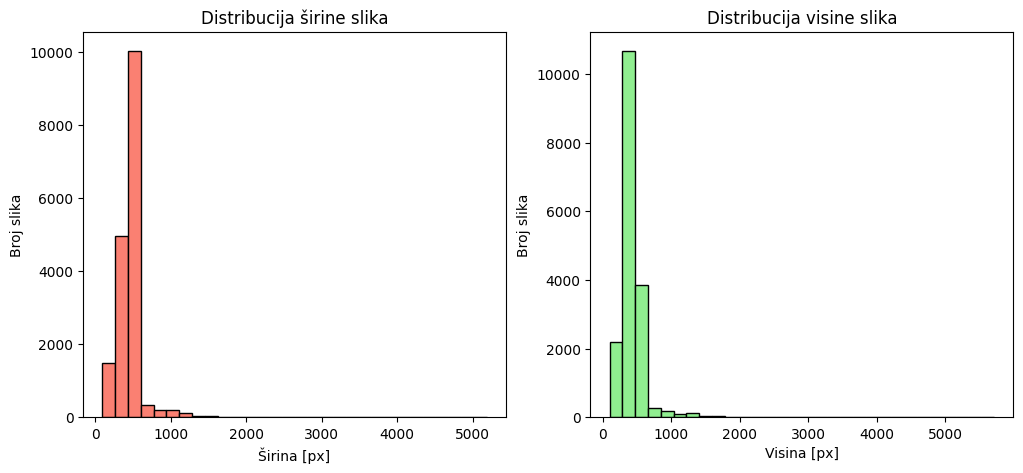

In [186]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=30, color='salmon', edgecolor='black')
plt.xlabel('Širina [px]')
plt.ylabel('Broj slika')
plt.title('Distribucija širine slika')

plt.subplot(1,2,2)
plt.hist(heights, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Visina [px]')
plt.ylabel('Broj slika')
plt.title('Distribucija visine slika')
plt.show()

### **Faza2**:Pipeline za treniranje, validaciju i testiranje modela

In [46]:
data_dir = r'data\DogBreedsImageDataset'

In [47]:
import os

In [48]:
def filter_classes_by_count(data_dir, min_samples=10):
    """
    Uklanja klase sa manje od min_samples primeraka
    """
    # Pronađi broj samples po klasi
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            num_samples = len([f for f in os.listdir(class_dir) 
                             if os.path.isfile(os.path.join(class_dir, f))])
            class_counts[class_name] = num_samples
    
    # Obriši klase sa premalo samples
    removed_count = 0
    for class_name, count in class_counts.items():
        if count < min_samples:
            class_dir = os.path.join(data_dir, class_name)
            shutil.rmtree(class_dir)  # Obriši celu direktorijum
            print(f"Obrisana klasa '{class_name}' sa {count} samples")
            removed_count += 1
    
    print(f"Ukupno obrisanih klasa: {removed_count}")
    return class_counts
class_counts = filter_classes_by_count(data_dir, min_samples=10)

# Prikaz preostalih klasa
print("\nPreostale klase:")
for class_name, count in sorted(class_counts.items()):
    if count >= 10:
        print(f"{class_name}: {count} samples")

Ukupno obrisanih klasa: 0

Preostale klase:
affenpinscher: 134 samples
afghan_hound: 125 samples
african: 169 samples
airedale: 189 samples
american_terrier: 153 samples
appenzeller: 135 samples
australian_cattledog: 18 samples
australian_terrier: 181 samples
basenji: 170 samples
basset_hound: 149 samples
beagle: 172 samples
bedlington_terrier: 148 samples
bernese_mountain: 190 samples
bichon_frise: 11 samples
blenheim_spaniel: 157 samples
blood_hound: 135 samples
bluetick: 147 samples
border_collie: 155 samples
border_terrier: 147 samples
borzoi: 107 samples
boston_bulldog: 173 samples
bouvier: 119 samples
boxer: 149 samples
brabancon: 141 samples
briard: 136 samples
brittany_spaniel: 136 samples
bull_mastiff: 137 samples
cairn_terrier: 177 samples
cardigan_corgi: 132 samples
caucasian_ovcharka: 30 samples
chesapeake_retriever: 142 samples
chihuahua: 129 samples
chow: 183 samples
clumber: 116 samples
cockapoo: 16 samples
cocker_spaniel: 174 samples
coonhound: 130 samples
curly_retriev

In [49]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [50]:
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

In [51]:
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

# Broj slika
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Random podela dataset-a
train_dataset, temp_dataset = random_split(
    full_dataset, 
    [train_size, total_size - train_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Za validacioni i test dataset menjamo transformacije (bez augmentacije)
val_size_from_temp = int(0.5 * len(temp_dataset))
test_size_from_temp = len(temp_dataset) - val_size_from_temp

val_dataset, test_dataset = random_split(
    temp_dataset,
    [val_size_from_temp, test_size_from_temp],
    generator=torch.Generator().manual_seed(42)
)

val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

def imshow_denormalized(img):
    # img: CxHxW tensor
    img = img.permute(1,2,0).numpy()  # CxHxW -> HxWxC
    mean = np.array([0.485,0.456,0.406])
    std  = np.array([0.229,0.224,0.225])
    img = std * img + mean           # denormalizacija
    img = np.clip(img, 0, 1)         # osiguravanje da bude u [0,1]
    return img

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    img = imshow_denormalized(images[i])
    axes[i].imshow(img)
    axes[i].set_title(full_dataset.classes[labels[i]])
    axes[i].axis("off")
plt.show()


In [52]:
class DogBreedCNN(nn.Module):
    def __init__(self, num_classes):
        super(DogBreedCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1: 64x64x3 → 32x32x32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 2: 32x32x32 → 16x16x64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 3: 16x16x64 → 8x8x128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 4: 8x8x128 → 4x4x256 (SAMO OVO DODAJTE)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        
        # Nova dimenzija: 256 * 4 * 4 = 4096
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),  # Povećano
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [53]:
num_classes = len(full_dataset.classes)
print(f"Broj klasa: {num_classes}")
print(f"Ukupno slika: {total_size}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Broj klasa: 124
Ukupno slika: 17390
Train: 12173, Val: 2608, Test: 2609


In [54]:
model = DogBreedCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
model.to(device)


DogBreedCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [56]:
'''# Proverite da li su podaci u redu
print("Provera podataka:")
for inputs, labels in train_loader:
    print(f"Input range: [{inputs.min():.3f}, {inputs.max():.3f}]")
    print(f"Labels: {labels.unique()}")
    break

# Proverite da li model može da overfit-uje na mali batch
test_batch = next(iter(train_loader))
inputs, labels = test_batch
inputs, labels = inputs.to(device), labels.to(device)

# Trenirajte samo na 1 batchu da vidite da li može da nauči
for i in range(100):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    if i % 20 == 0:
        _, preds = torch.max(outputs, 1)
        correct = (preds == labels).sum().item()
        total = labels.size(0)
        accuracy = correct / total
        print(f"Step {i}: Loss {loss.item():.4f}, Accuracy: {accuracy*100:.2f}%")

# Ako loss ne pada, NEŠTO JE FUNDAMENTALNO LOŠE'''

'# Proverite da li su podaci u redu\nprint("Provera podataka:")\nfor inputs, labels in train_loader:\n    print(f"Input range: [{inputs.min():.3f}, {inputs.max():.3f}]")\n    print(f"Labels: {labels.unique()}")\n    break\n\n# Proverite da li model može da overfit-uje na mali batch\ntest_batch = next(iter(train_loader))\ninputs, labels = test_batch\ninputs, labels = inputs.to(device), labels.to(device)\n\n# Trenirajte samo na 1 batchu da vidite da li može da nauči\nfor i in range(100):\n    optimizer.zero_grad()\n    outputs = model(inputs)\n    loss = criterion(outputs, labels)\n    loss.backward()\n    optimizer.step()\n\n    if i % 20 == 0:\n        _, preds = torch.max(outputs, 1)\n        correct = (preds == labels).sum().item()\n        total = labels.size(0)\n        accuracy = correct / total\n        print(f"Step {i}: Loss {loss.item():.4f}, Accuracy: {accuracy*100:.2f}%")\n\n# Ako loss ne pada, NEŠTO JE FUNDAMENTALNO LOŠE'

In [57]:
import time
from datetime import datetime

num_epochs = 40

for epoch in range(num_epochs):
    # ================= Training Phase =================
    model.train()
    running_loss = 0.0
    running_corrects = 0
    start_time = time.time()
    start_timestamp = datetime.now()
    
    print(f"Epoch {epoch+1} started at {start_timestamp.strftime('%Y-%m-%d %H:%M:%S')}")

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    
    end_time = time.time()
    end_timestamp = datetime.now()
    epoch_duration = end_time - start_time
    
    print(f"Training - Epoch {epoch+1} finished at {end_timestamp.strftime('%Y-%m-%d %H:%M:%S')}, "
          f"Duration: {epoch_duration:.2f} sec, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # ================= Validation Phase =================
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)
    
    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects.double() / len(val_dataset)
    
    print(f"Validation - Epoch {epoch+1} Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}\n")


Epoch 1 started at 2025-09-03 01:54:49
Training - Epoch 1 finished at 2025-09-03 01:56:45, Duration: 115.89 sec, Loss: 4.7139, Accuracy: 0.0178
Validation - Epoch 1 Loss: 4.4988, Accuracy: 0.0288

Epoch 2 started at 2025-09-03 01:57:11
Training - Epoch 2 finished at 2025-09-03 01:59:00, Duration: 108.22 sec, Loss: 4.4300, Accuracy: 0.0343
Validation - Epoch 2 Loss: 4.3181, Accuracy: 0.0429

Epoch 3 started at 2025-09-03 01:59:25
Training - Epoch 3 finished at 2025-09-03 02:01:09, Duration: 103.64 sec, Loss: 4.2968, Accuracy: 0.0413
Validation - Epoch 3 Loss: 4.2229, Accuracy: 0.0571

Epoch 4 started at 2025-09-03 02:01:32
Training - Epoch 4 finished at 2025-09-03 02:03:24, Duration: 112.06 sec, Loss: 4.2015, Accuracy: 0.0453


KeyboardInterrupt: 